# Tutorial

The objective of this tutorial is to get up and running a minimal training run 
for the poregen. We will go through all the steps necessary for this run.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pathlib

import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.transforms.v2 as transforms
import skimage
import lightning
import lightning.pytorch.callbacks as callbacks
import porespy

import diffsci.models
from poregen.data import VoxelToSlicesDataset

/home/danilo/miniconda3/envs/ddpm_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
MAINFOLDER = pathlib.Path("../..") #This leads to the main folder
RAWDATAFOLDER = MAINFOLDER/"saveddata"/"raw" #This leads to the data folder
MODELSPATH = MAINFOLDER/"savedmodels" #This leads to the models folder

We first load our Berea sandstone binarized file.

In [5]:
def load_berea(path):
    """
    This function takes a .raw file of a 1000x1000x1000 binarized 
    sandstone, converts it to an numpy of type uint8, and reshapes it
    to the shape [1000, 1000, 1000].
    *Unless I (Danilo) am wrong*, the format is as following:
    the first axis corresponds to the z direction, 
    the second axis corresponds to the x direction,
    and the third axis corresponds to the y direction.
    ---
    input: path : str
        Path to file
    output: voxel : np.array
        voxel, where 1 corresponds to solid, and 0 corresponds to void.
    """
    with open(path, 'rb') as f:
        voxel = np.fromfile(f, dtype=np.uint8)
    voxel = voxel.reshape((1000, 1000, 1000))
    return voxel
name = "eleven_sandstones/Berea_2d25um_binary.raw"
path = RAWDATAFOLDER/name
voxel = load_berea(path)


In [6]:
voxel.shape

(1000, 1000, 1000)

In [7]:
def reduce_resolution(voxel, block_size, threshold='mean'):
    """
    This is an auxiliary function to reduce 
    """
    mean = skimage.measure.block_reduce(voxel, block_size=block_size, func=np.mean)
    if threshold == 'mean':
        threshold = voxel.mean()
    elif threshold == 'any':
        threshold = 0.0
    reduced_voxel = (mean > threshold).astype(int)
    return reduced_voxel

reduced_voxel = reduce_resolution(voxel, block_size=4, threshold='mean')
train_voxel = reduced_voxel[:200, :, :] #Separate in train voxel 
valid_voxel = reduced_voxel[200:, :, :] #Separate in validation voxeo

Let's plot our berea voxels

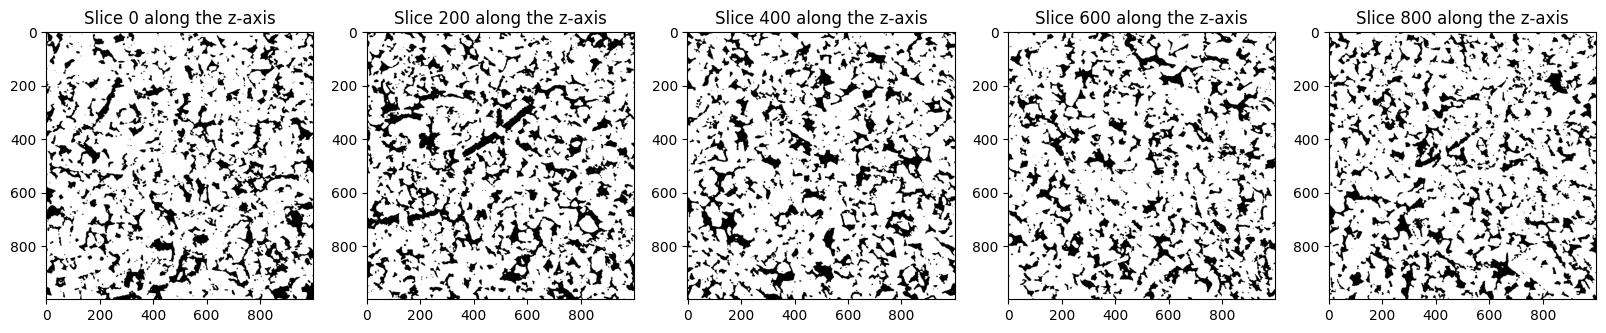

In [8]:
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
axes = axes.flatten()
# Generate slices and plot
for axind, sliceind in enumerate(range(0, 1000, 200)):  # Increment of 16 to skip some slices for brevity
    axes[axind].imshow(voxel[sliceind, :, :], cmap='gray')  # alpha for transparency
    axes[axind].set_title(f"Slice {sliceind} along the z-axis")


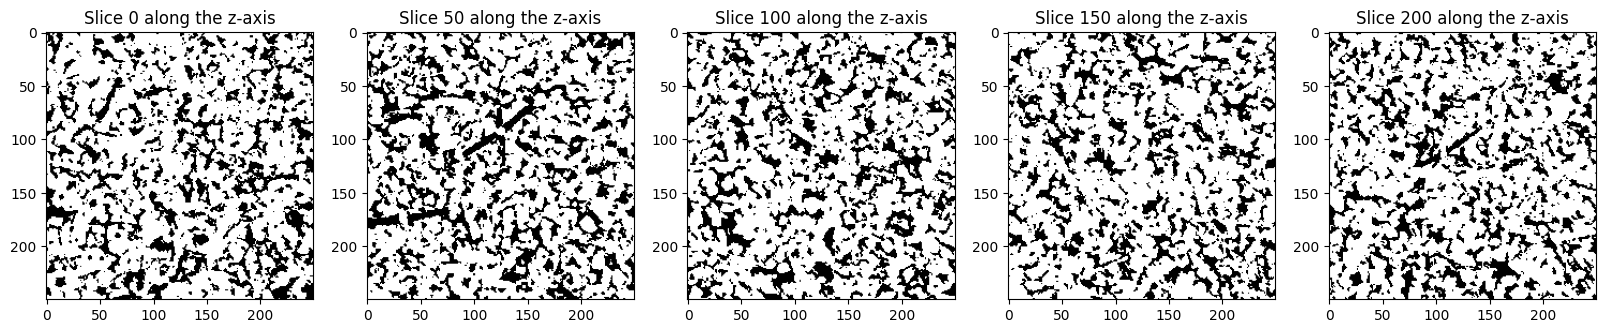

In [9]:
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
axes = axes.flatten()
# Generate slices and plot
for axind, sliceind in enumerate(range(0, 250, 50)):  # Increment of 16 to skip some slices for brevity
    axes[axind].imshow(reduced_voxel[sliceind, :, :], cmap='gray')  # alpha for transparency
    axes[axind].set_title(f"Slice {sliceind} along the z-axis")


In [10]:
batch_size = 16
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5)
])

train_dataset = VoxelToSlicesDataset(train_voxel, transform=transform, image_size=48)
val_dataset = VoxelToSlicesDataset(valid_voxel, transform=transform, image_size=48)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

In [11]:
x = next(iter(train_dataloader))

Text(0.5, 1.0, 'A image of the training dataset')

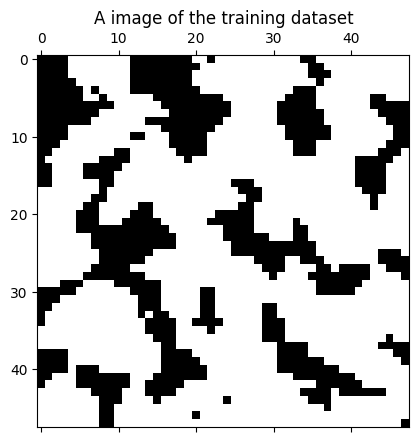

In [12]:
x = next(iter(train_dataloader))
plt.matshow(x[0][0], cmap='gray')
plt.title("A image of the training dataset")

Let's prepare and train our model

In [13]:
modelconfig = diffsci.models.PUNetGConfig(model_channels=32, dropout=0.1)
model = diffsci.models.PUNetG(modelconfig)
config = diffsci.models.KarrasModuleConfig.from_edm(sigma_data=0.5)
module = diffsci.models.KarrasModule(model, config)

In [14]:
checkpoint_callback = callbacks.ModelCheckpoint(
    monitor='val_loss',
    dirpath=MODELSPATH/"tutorial-0001-berea",
    filename='sample-bead-{epoch:02d}-{val_loss:.6f}',
    save_top_k=3,
    mode='min',
)

In [15]:
module.optimizer = torch.optim.AdamW(module.parameters(),
                                    lr=2*1e-5)
module.lr_scheduler = None

In [16]:
trainer = lightning.Trainer(max_epochs=20,
                            callbacks=[checkpoint_callback])
trainer.fit(model=module,
            train_dataloaders=train_dataloader,
            val_dataloaders=val_dataloader)

Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/home/danilo/miniconda3/envs/ddpm_env/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: Checkpoint directory /home/danilo/repos/PoreGen/savedmodels/tutorial-0001-berea exists

Epoch 0:   8%|▊         | 169/2160 [00:05<01:01, 32.59it/s, v_num=4, train_loss=0.431]

/home/danilo/miniconda3/envs/ddpm_env/lib/python3.11/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [23]:
checkpoint_path = MAINFOLDER/\
    "savedmodels/tutorial-0001-berea/sample-bead-epoch=00-val_loss=0.215259.ckpt"
loaded_module = diffsci.models.KarrasModule.load_from_checkpoint(checkpoint_path, model=model, config=config)

In [37]:
sample_history = loaded_module.sample(nsamples=64, shape=[1, 48, 48], record_history=True)
samples = sample_history[-1]

In [47]:
samples_validation = torch.stack([
                            val_dataset[i] for i in range(16*4)
                        ], axis=0)
sample_history.shape, samples.shape, samples_validation.shape

(torch.Size([101, 64, 1, 48, 48]),
 torch.Size([64, 1, 48, 48]),
 torch.Size([64, 1, 48, 48]))

In [48]:
def binarize(x):
    dims = list(range(1, len(x.shape)))
    return x > (x.mean(dim=dims, keepdim=True))

samples_binarized = binarize(samples)
samples_validation_binarized = binarize(samples_validation)


In [49]:
def scaled_tpc(tpc):
    x = tpc.distance
    porosity = tpc.probability_scaled[0]
    ub = porosity
    lb = porosity**2
    y0 = tpc.probability_scaled
    y = (y0 - lb)/(ub - lb)
    return x, y

ys_generated_list = []
ys_valid_list = []

for i in range(64):
    # tpc = porespy.metrics.two_point_correlation(x_net[i])
    # plt.plot(tpc.distance, tpc.pdf, color='red', alpha=0.1)
    blue_label = "generated" if i == 0 else None
    red_label = "validation" if i == 0 else None
    tpc = porespy.metrics.two_point_correlation((~samples_binarized[i][0]).cpu().numpy())
    xs_generated, ys_generated = scaled_tpc(tpc)
    tpc = porespy.metrics.two_point_correlation((~samples_validation_binarized[i][0]).numpy())
    xs_valid, ys_valid = scaled_tpc(tpc)
    ys_generated_list.append(ys_generated)
    ys_valid_list.append(ys_valid)

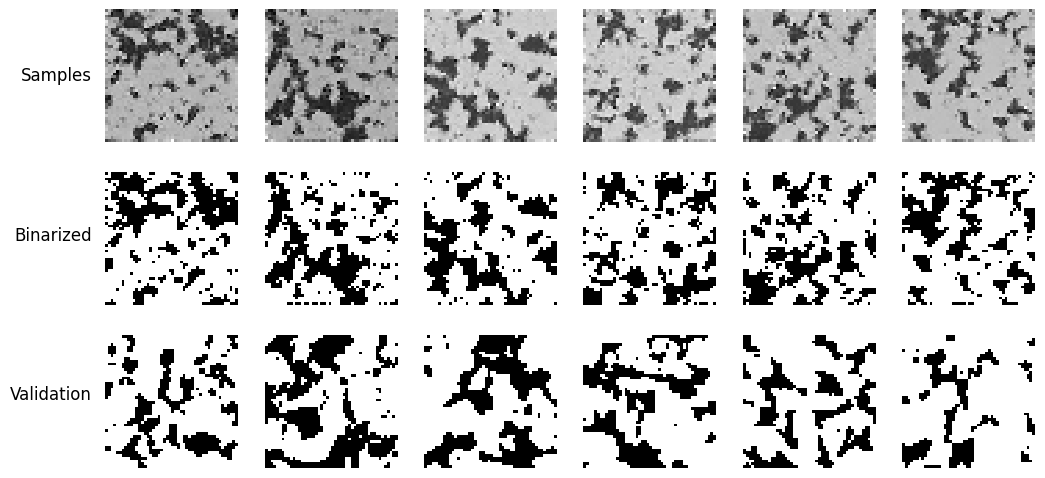

In [50]:
fig, axes = plt.subplots(3, 6, figsize=(12, 6))
for ax in axes.flatten():
    ax.axis('off')

# Define your row labels
row_labels = ["Samples", "Binarized", "Validation"]

# Set the positions for the labels
label_x_position = -0.1  # Adjust as needed
label_y_positions = [0.5, -0.7, -1.9]  # Adjust as needed based on your figure size and layout

for i, label in enumerate(row_labels):
    # Add text to the figure, not to an individual axis
    fig.text(label_x_position, label_y_positions[i], label, va='center', ha='right', fontsize=12, transform=axes[0, 0].transAxes)

for i in range(axes.shape[1]):
    j = i + 10
    axes[0, i].matshow(samples[j][0].cpu().detach().numpy(), cmap="gray")
    axes[1, i].matshow(samples_binarized[j][0].cpu().detach().numpy(), cmap="gray")
    axes[2, i].matshow(samples_validation[j][0].cpu().detach().numpy(), cmap="gray")

In [51]:
mean_ys_generated = np.mean(np.stack(ys_generated_list, axis=0), 0)
std_ys_generated = np.std(np.stack(ys_generated_list, axis=0), 0)
mean_ys_valid = np.mean(np.stack(ys_valid_list, axis=0), 0)
std_ys_valid = np.std(np.stack(ys_valid_list, axis=0), 0)

Text(0.5, 1.0, 'Comparison of two point correlation')

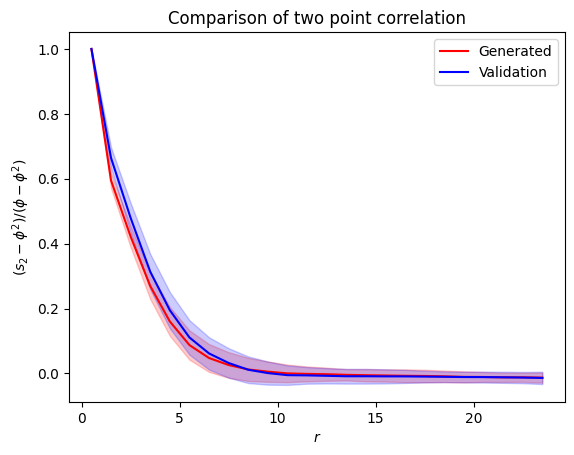

In [ ]:
plt.fill_between(xs_generated,
                 y1=mean_ys_generated-1*std_ys_generated,
                 y2=mean_ys_generated+1*std_ys_generated, color='red', alpha=0.2)
plt.fill_between(xs_valid,
                 y1=mean_ys_valid-1*std_ys_valid,
                 y2=mean_ys_valid+1*std_ys_valid, color='blue', alpha=0.2)
plt.plot(xs_generated, mean_ys_generated, color='red', label='Generated')
plt.plot(xs_valid, mean_ys_valid, color='blue', label='Validation')
plt.xlabel(r"$r$")
plt.ylabel(r"$(s_2 - \phi^2)/(\phi - \phi^2)$")
plt.legend()
plt.title("Comparison of two point correlation")
# plt.savefig(FIGURESPATH/"06122022-tpc.jpg")

In [55]:
porosity_net = [porespy.metrics.porosity(~x) for x in samples_binarized.squeeze(1).cpu()]
porosity_net_filtered = [porespy.metrics.porosity(~x) for x in samples_binarized.squeeze(1).cpu()]
porosity_true = [porespy.metrics.porosity(~x) for x in samples_validation_binarized.squeeze(1)]

Text(0.5, 1.0, 'Porosity histogram')

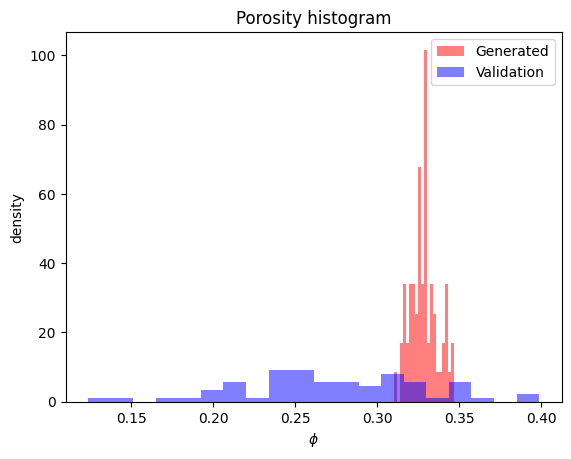

In [56]:
plt.hist(porosity_net_filtered, bins=20, alpha=0.5, color='red', density=True, label='Generated');
plt.hist(porosity_true, bins=20, alpha=0.5, color='blue', density=True, label='Validation');
plt.xlabel(r"$\phi$")
plt.ylabel("density")
plt.legend()
plt.title("Porosity histogram")
# plt.savefig(FIGURESPATH/"06122022-porosity.jpg")
